# Dekompozycja QR

## Definicje metod

Poniżej znajdują się definicje metod omawianych w sprawozdaniu:

In [62]:
# Biblioteka potrzebna żeby zwracać R jako macierz górnotrójkątną
# oszczędność pamięciowa i czasowa
using LinearAlgebra 

# Funkcje pomocnicze
function vectorNorm(vec1, vec2)
    return transpose(vec1)*(vec2)
end

function vecProjection(u, vec)
    return vectorNorm(u, vec)/vectorNorm(u,u) * u
end

function vecNormalize(vec)
    return sqrt(1 / vectorNorm(vec, vec)) * vec
end

# ------------------------------------------------------
#               Algorytm Grama Schmidta
# ------------------------------------------------------

function GramSchmidt(mat)

    baseU = Matrix{Float64}(undef, size(mat, 1), 0)
    baseE = Matrix{Float64}(undef, size(mat, 1), 0)

    # wyliczanie bazy E oraz U
    for i in 1:size(mat, 1)
        u = mat[:, i]
        for j in 1:(i-1)
            u = u - vecProjection(baseU[:, j], mat[:, i])
        end

        baseU = hcat(baseU, u)
        baseE = hcat(baseE, vecNormalize(u))
    end
    
    # wyliczanie macierzy R
    R = Matrix{Float64}(undef, size(mat, 1), size(mat, 1))
    for i in 1:size(mat, 1)
        for j in 1:size(mat, 1)
            R[i, j] = vectorNorm(baseE[:, i], mat[:, j])
        end
    end

    baseE, UpperTriangular(R)
end

GramSchmidt (generic function with 1 method)

In [63]:
# ------------------------------------------------------
#         Zmodyfikowany Algorytm Grama Schmidta
# ------------------------------------------------------

function MGS(mat)
    n = size(mat, 2)
    baseU = [mat[:, i] for i in 1:n]
    
    for i in 1:n
        for j in (i+1):n
            baseU[j] = baseU[j] - vecProjection(baseU[i], baseU[j])
        end
    end
    
    baseE = Matrix{Float64}(undef, n, 0)
    
    for i in 1:n
        baseE = hcat(baseE, vecNormalize(baseU[i]))
    end
    
    return baseE, transpose(baseE)*mat
    
end

MGS (generic function with 1 method)

In [64]:
# ------------------------------------------------------
#               Algorytm Householdera
# ------------------------------------------------------

function Householder(A)
    # rozmiar macierzy
    n = size(A, 2)
    
    # tworzy macierz Householdera ze wzoru
    function Hn(vec)
        vn = vec
        vn[1] -= sqrt(vectorNorm(vec, vec))
        return I - (2*vn*transpose(vn))/(transpose(vn)*vn)
    end
    
    # nakładanie macierzy H na Id, otrzymujemy H'
    function Hpn(mat)
        m = size(mat, 1)
        d = n - m
        res = convert(Matrix{Float64}, I[1:n, 1:n])
        for i in 1:m
            for j in 1:m
                res[d + i, d + j] = mat[i, j]
            end
        end
        return res
    end
    
    Q = I[1:n, 1:n]
    R = A
    # Iterowanie po rzędzach, branie podmacierzy i obliczanie kolejnych Hn
    for i = 1:1:n-1 
        Sub = R[i:n, i:n]
        Hp = Hpn(Hn(Sub[:, 1]))
        R = Hp*R
        Q = Q*Hp
    end
    
    return Q, UpperTriangular(R)
end

Householder (generic function with 1 method)

## Testy wybranych algorytmów



In [65]:

# Losowa macierz
function RandomMatrix(size, rad)
    R = Matrix{Float64}(undef, size, 0)
    for i in 1:size 
        R = hcat(R, rand(size) * rad .- (rad/2))
    end
    return R
end 
R = (RandomMatrix(30, 10^10))

# Funkcja dodająca zaburzenie do macierzy M
function addRandomNoise(M, amount=0.01)
    noise = rand(Float64, size(M))
    noise = noise .* 2 .- 1 
    noise = noise .* amount
    #uniform distribution from -amount to amount
    return M+noise
end

# Norma do porównywania macierzy zdefiniowana w sprawozdaniu
function matNorm(M)
    sum = 0
    for i in M; sum += abs(i); end
    return sum/(size(M, 1)*size(M, 2))
end

# Testowanie stabilności numerycznej dla pojedynczego zaburzenia macierzy
function checkChange(M, decomp; verbose = true, noise = true)
    noisy = noise
    if(noisy === true); noisy = addRandomNoise(M); end
    
    if(verbose); println("Total change in arguments ", sum(noisy-M)); end
    q, r = decomp(M)
    qn, rn = decomp(noisy)
    siz = size(M)[1]*size(M)[2]
    
    
    averageChange = (sum(M-q*r)-sum(noisy-qn*rn))/siz
    
    if(verbose)
        println("Total change in Q ", sum(qn-q))
        println("Average change in Q ", sum(qn-q)/siz)
        println("Total change in R ", sum(rn-r))
        println("Average change in R ", sum(rn-r)/siz)
        println("|ΔQ|/|Δarg| ", sum(qn-q)/sum(noisy-M))
        println("|Δq|/|Δarg| ", sum(qn-q)/(siz*sum(noisy-M)))
        println("|ΔR|/|Δarg| ", sum(rn-r)/sum(noisy-M))
        println("|Δr|/|Δarg| ", sum(rn-r)/(siz*sum(noisy-M)))
        println("Total change in M-Q*R ", sum(M-q*r)-sum(noisy-qn*rn))
        println("Average change in M-Q*R ", averageChange)
    end
    
    return matNorm(M - q*r - noisy + qn*rn)

end

checkChange (generic function with 1 method)

In [66]:
checkChange([1.0 2.0 3.0; 4.0 5.0 6.0; 7.0 8.0 9.0], Householder, verbose = true)

Total change in arguments -0.017569839730182557
Total change in Q 0.014620564370069866
Average change in Q 0.0016245071522299852
Total change in R 0.0041007046280152615
Average change in R 0.00045563384755725126
|ΔQ|/|Δarg| -0.8321398825826372
|Δq|/|Δarg| -0.09245998695362635
|ΔR|/|Δarg| -0.2333945380828271
|Δr|/|Δarg| -0.025932726453647456
Total change in M-Q*R -9.992007221626409e-16
Average change in M-Q*R -1.1102230246251565e-16


9.74529099393193e-16

### Test stabilności numerycznej

Bierzemy losową macierz i zaburzamy ją kilkukrotnie. Równocześnie porównujemy jak dobrze dokładność w obliczeniach metod między kolejnymi iteracjami zaburzeń

In [67]:
using Plots

function StabilityRace(len, startRange, noise)
    
    t = RandomMatrix(10, startRange)
    org = t
    perturb = addRandomNoise(t, noise)
    
    xs, ys, zs = [], [], []
    
    for i in 1:len
        push!(xs, checkChange(t, GramSchmidt; verbose = false, noise = perturb))
        push!(ys, checkChange(t, MGS;         verbose = false, noise = perturb))
        push!(zs, checkChange(t, Householder; verbose = false, noise = perturb))
        
        t = perturb
        perturb = addRandomNoise(t, noise)
    end
    
    range = collect(1:len)
    
    plot(range, log10.(abs.(xs)), title="Stabilność numeryczne - rzędy błędów", xlabel="numer iteracji", label ="Gram-Schmidt")
    plot!(range, log10.(abs.(ys)), label ="MGS")
    plot!(range, log10.(abs.(zs)), label ="Householder")

end

StabilityRace (generic function with 1 method)

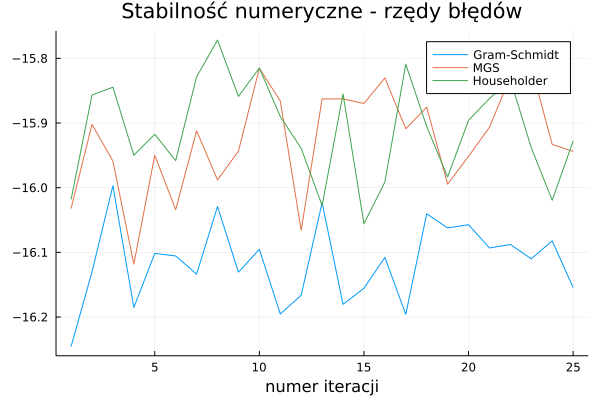

In [68]:
StabilityRace(25, 1, 0.001)

### Stabilność numerczna wraz ze zwiększaniem zaburzenia

Test podobny do powyższego ale tym razem zwiększa się promień losowanych zaburzeń
    

In [69]:
function StabilityWithIncreasingNoise(len, startRange,step, startNoise)
    noise =startNoise
    t = RandomMatrix(10, startRange)
    org = t
    
    
    xs, ys, zs = [], [], []
    range =[]
    for i in 1:len
        perturb = addRandomNoise(t, noise)
        push!(range, noise)
        noise += step
        push!(xs, checkChange(t, GramSchmidt; verbose = false, noise = perturb))
        push!(ys, checkChange(t, MGS;         verbose = false, noise = perturb))
        push!(zs, checkChange(t, Householder; verbose = false, noise = perturb))
        
    end
    
    
    
    plot(range, log10.(abs.(xs)), title="Stabilność numeryczna - rzędy błędów", xlabel="Rozmiar zaburzeń", label ="Gram-Schmidt")
    plot!(range, log10.(abs.(ys)), label ="MGS")
    plot!(range, log10.(abs.(zs)), label ="Householder")

end

StabilityWithIncreasingNoise (generic function with 1 method)

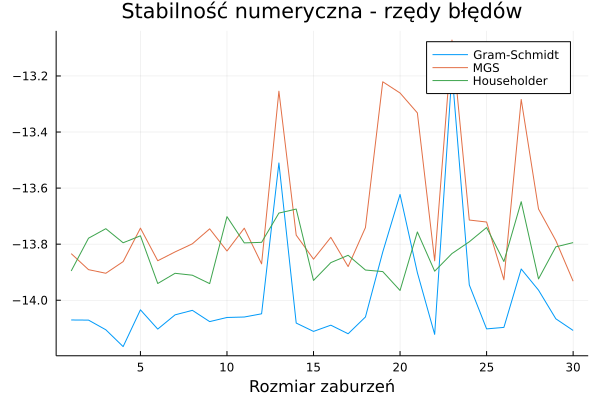

In [70]:
StabilityWithIncreasingNoise(30, 100, 1, 1)

### Dokładność rozkładu wraz ze wzrostem rozmiaru macierzy

In [71]:
function RandomRadiusRace(rad, it, tests)
    xs, ys, zs = [], [], []
    s = 3
    for i in 1:it
        push!(xs, 0)
        push!(ys, 0)
        push!(zs, 0)
        
        
        
        for j in 1:tests
            t = RandomMatrix(s, rad)
            
            Q, R = GramSchmidt(t)
            xs[i] += matNorm(t - Q*R)
            
            Q, R = MGS(t)
            ys[i] += matNorm(t - Q*R)
            
            Q, R = Householder(t)
            zs[i] += matNorm(t - Q*R)
        end
        
        s += 1;
    end
    
    range = collect(1:it)
    
    plot(range,  log10.(xs ./ tests), title="Precyzja obliczeń wraz ze wzrostem rozmiaru", xlabel="Rozmiar macierzy", label ="Gram-Schmidt")
    plot!(range, log10.(ys ./ tests), label ="MGS")
    plot!(range, log10.(zs ./ tests), label ="Householder")
end

RandomRadiusRace (generic function with 1 method)

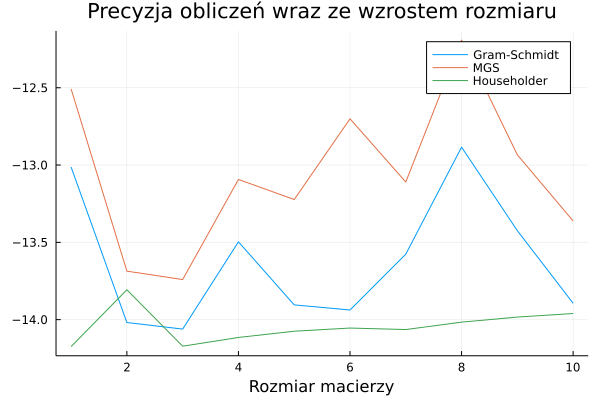

In [72]:
RandomRadiusRace(100, 10, 100)

### Rozwiązywanie losowych układów równań

In [73]:
function solveLinearSystem(M, ys, decomp=GramSchmidt)
    q, r = decomp(M)
    
    ys = transpose(q)*transpose(ys)
    
    solutions = zeros(Float64, size(ys))
    n = size(ys)[1]

    for i in n:-1:1
        sub = 0
        for j in n:-1:i+1
            sub += solutions[j]*r[i,j]
        end
        solutions[i]=(ys[i]-sub)/r[i,i]
    end
    
    #x = r\ys for debug purposes only
    return solutions
end


function GenerateRandomLinearSystem(siz, rad=10^8)
    coeffs = RandomMatrix(siz, rad)
    xs = rand(Float64, siz) .*rad .-(rad/2)
    ys = zeros(Float64, siz)
    for i in 1:siz
        for j in 1:siz
            ys[i] = ys[i]+coeffs[i,j]*xs[j]
        end
    end
    return coeffs, xs, transpose(ys)
end

function CompareSystemSolution(decomp, M, xs, ys, verbose=false)
    solution = solveLinearSystem(M, ys, decomp)
    if verbose==true
        println(xs-solution)
        println(sum(xs-solution)/size(xs)[1])
    end
    return sum(xs-solution)/size(xs)[1]
end

CompareSystemSolution (generic function with 2 methods)

In [74]:
M, xs, ys = GenerateRandomLinearSystem(10)
println(CompareSystemSolution(Householder, M, xs, ys))
println(CompareSystemSolution(MGS, M, xs, ys))
println(CompareSystemSolution(GramSchmidt, M, xs, ys))

-2.7474015951156618e-9
1.5972182154655455e-8
-2.5564804673194885e-8


In [75]:
function RandomRadiusSolutionRace(rad, it ,tests)
    xs, ys, zs = [], [], []
    
    for i in 1:it
        push!(xs, 0)
        push!(ys, 0)
        push!(zs, 0)
        
        
        for j in 1:tests
            M, a, b = GenerateRandomLinearSystem(10, rad)
            
            
            xs[i] += abs(CompareSystemSolution(GramSchmidt, M, a, b))#abs(sum(t - Q*R))
            
            ys[i] += abs(CompareSystemSolution(MGS, M, a, b))#abs(sum(t - Q*R))
            

            zs[i] += abs(CompareSystemSolution(Householder, M, a, b))#abs(sum(t - Q*R))
        end
        
        rad *= 2;
    end
    
    range = collect(1:it)
    
    plot(range,  log10.(xs ./ tests), label="Gram-Schmidt")
    plot!(range, log10.(ys ./ tests), label="MGS")
    plot!(range, log10.(zs ./ tests), label="Householder")
    

end

RandomRadiusSolutionRace (generic function with 1 method)

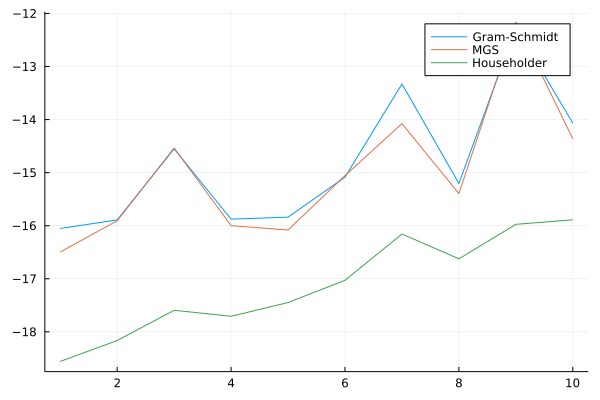

In [76]:
RandomRadiusSolutionRace(0.001, 10, 100)

In [ ]:
Test